In [1]:
# pyg-team
# from: https://paperswithcode.com/paper/variational-graph-normalized-auto-encoders

In [2]:
import os.path as ospath
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import torch
from torch.nn import Linear, LeakyReLU
from sklearn.metrics import roc_auc_score
from torch_geometric.nn import GCNConv
from torch_geometric.utils import negative_sampling
from torch_geometric.data import Data, Dataset
import torch_geometric.transforms as T

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

## load data

In [3]:
prefix1 = 'dataset1'
prefix2 = 'dataset2'
prefix3 = 'dataset3'

df_train1 = pd.read_csv(f'{prefix1}/train.csv')
df_test1 = pd.read_csv(f'{prefix1}/test.csv')
df_content1 = pd.read_csv(f'{prefix1}/content.csv', sep='\t', header=None, index_col=0)

df_train2 = pd.read_csv(f'{prefix2}/train.csv')
df_test2 = pd.read_csv(f'{prefix2}/test.csv')
df_content2 = pd.read_csv(f'{prefix2}/content.csv', sep='\t', header=None, index_col=0)

df_train3 = pd.read_csv(f'{prefix3}/train.csv')
df_test3 = pd.read_csv(f'{prefix3}/test.csv')
df_content3 = pd.read_csv(f'{prefix3}/content.csv', sep='\t', header=None, index_col=0)

df_content1 = df_content1.sort_index()
df_content2 = df_content2.sort_index()
df_content3 = df_content3.sort_index()

In [4]:
def print_shape(df_train, df_test, df_content):
    print(f"{'Train Shape':<15}: {df_train.shape}")
    print(f"{'Test Shape':<15}: {df_test.shape}")
    print(f"{'Content Shape':<15}: {df_content.shape}")

print_shape(df_train1, df_test1, df_content1)

Train Shape    : (8686, 4)
Test Shape     : (2172, 3)
Content Shape  : (2708, 1433)


In [5]:
def df2data(df_train, df_test, df_content):
    X = torch.tensor(df_content.values, dtype=torch.float32)
    mask_pos = (df_train['label'] == 1)
    train_edge_index = torch.tensor(df_train.loc[mask_pos, ['from', 'to']].values).T
    train_edge_label_index = torch.tensor(df_train.loc[mask_pos, ['from', 'to']].values).T
    train_edge_neg_label_index = torch.tensor(df_train.loc[~mask_pos, ['from', 'to']].values).T
    train_edge_label = torch.ones(size=(train_edge_label_index.shape[1], ))

    test_edge_label_index = torch.tensor(df_test.iloc[:, 1:3].values).T


    train_data = Data(x=X, edge_index=train_edge_index, 
                      edge_label_index=train_edge_label_index, edge_label=train_edge_label,
                      edge_neg_label_index=train_edge_neg_label_index)
    test_data = Data(x=X, edge_index=train_edge_index, edge_label_index=test_edge_label_index)
    return train_data, test_data

train_data1, test_data1 = df2data(df_train1, df_test1, df_content1)
train_data2, test_data2 = df2data(df_train2, df_test2, df_content2)
train_data3, test_data3 = df2data(df_train3, df_test3, df_content3)

In [6]:
[train_data1, test_data1]

[Data(x=[2708, 1433], edge_index=[2, 4324], edge_label_index=[2, 4324], edge_label=[4324], edge_neg_label_index=[2, 4362]),
 Data(x=[2708, 1433], edge_index=[2, 4324], edge_label_index=[2, 2172])]

## train val split

In [7]:
def train_val_split(train_data):
    ran_link_split = T.RandomLinkSplit(num_val=0.05, num_test=0,
                                    is_undirected=True,
                                    add_negative_train_samples=False)
    train_data, val_data, _ = ran_link_split(train_data)
    return train_data, val_data
    
# train_data1, val_data1 = train_val_split(train_data1)
# train_data2, val_data2 = train_val_split(train_data2)
# train_data3, val_data3 = train_val_split(train_data3)

## preprocessing

In [8]:
train_data1

Data(x=[2708, 1433], edge_index=[2, 4324], edge_label_index=[2, 4324], edge_label=[4324], edge_neg_label_index=[2, 4362])

In [9]:
transform = T.Compose([
    T.NormalizeFeatures(),
    T.ToDevice(device),
])
train_data1, test_data1 = transform(train_data1), transform(test_data1)
train_data2, test_data2 = transform(train_data2), transform(test_data2)
train_data3, test_data3 = transform(train_data3), transform(test_data3)

In [10]:
negative_sampling(train_data1.edge_index)

tensor([[1305, 1360, 1181,  ..., 1229, 1327, 2704],
        [ 506, 1784, 1051,  ..., 1883, 2585,  995]], device='cuda:0')

In [11]:
((train_data1.edge_index[0] == 2399) & (train_data1.edge_index[1] == 2339)).sum()

tensor(0, device='cuda:0')

In [12]:
train_data1.edge_label

tensor([1., 1., 1.,  ..., 1., 1., 1.], device='cuda:0')

In [16]:
import os.path as osp
import argparse

import torch
import torch.nn as nn
import torch.nn.functional as F

from torch_geometric.datasets import Planetoid, Coauthor, Amazon
from torch_geometric.utils import train_test_split_edges
from torch_geometric.nn import GAE, VGAE, APPNP
import torch_geometric.transforms as T

# parser = argparse.ArgumentParser()
# parser.add_argument('--model', type=str, default='VGNAE')
# parser.add_argument('--dataset', type=str, default='Cora')
# parser.add_argument('--epochs', type=int, default=300)
# parser.add_argument('--channels', type=int, default=128)
# parser.add_argument('--scaling_factor', type=float, default=1.8)
# parser.add_argument('--training_rate', type=float, default=0.8) 
# args = parser.parse_args()
args = {
    "model": 'VGNAE',
    'dataset': 'Cora',
    'epochs': 300,
    'channels': 128,
    'scaling_factor': 1.8,
    'training_rate': 0.8
}

path = '../Planetoid/Cora'
dataset = Planetoid(path, args['dataset'], 'public')
data = dataset[0]
data = T.NormalizeFeatures()(data)


dev = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
channels = args['channels']
train_rate = args['training_rate']
val_ratio = (1-args['training_rate']) / 3
test_ratio = (1-args['training_rate']) / 3 * 2


class Encoder(torch.nn.Module):
    def __init__(self, in_channels, out_channels, edge_index):
        super(Encoder, self).__init__()
        self.linear1 = nn.Linear(in_channels, out_channels)
        self.linear2 = nn.Linear(in_channels, out_channels)
        self.propagate = APPNP(K=1, alpha=0)

    def forward(self, x, edge_index,not_prop=0):
        x_ = self.linear1(x)
        x_ = self.propagate(x_, edge_index)

        x = self.linear2(x)
        x = F.normalize(x,p=2,dim=1) * args['scaling_factor']
        x = self.propagate(x, edge_index)
        return x, x_
    
data = train_test_split_edges(data.to(dev), val_ratio=val_ratio, test_ratio=test_ratio)
print(data)
N = int(data.x.size(0))
model = VGAE(Encoder(data.x.size()[1], channels, data.train_pos_edge_index)).to(dev)

data.train_mask = data.val_mask = data.test_mask = data.y = None
x, train_pos_edge_index = data.x.to(dev), data.train_pos_edge_index.to(dev)
optimizer = torch.optim.Adam(model.parameters(), lr=0.005)

Data(x=[2708, 1433], y=[2708], train_mask=[2708], val_mask=[2708], test_mask=[2708], val_pos_edge_index=[2, 351], test_pos_edge_index=[2, 703], train_pos_edge_index=[2, 8448], train_neg_adj_mask=[2708, 2708], val_neg_edge_index=[2, 351], test_neg_edge_index=[2, 703])


/home/littlemilk/miniconda3/envs/jupyterhub/lib/python3.9/site-packages/torch_geometric/deprecation.py:12: UserWarning: 'train_test_split_edges' is deprecated, use 'transforms.RandomLinkSplit' instead
  warnings.warn(out)


In [17]:

def train():
    model.train()
    optimizer.zero_grad()
    z  = model.encode(x, train_pos_edge_index)
    loss = model.recon_loss(z, train_pos_edge_index)
    loss = loss + (1 / data.num_nodes) * model.kl_loss()
    loss.backward()
    optimizer.step()
    return loss

def test(pos_edge_index, neg_edge_index, plot_his=0):
    model.eval()
    with torch.no_grad():
        z = model.encode(x, train_pos_edge_index)
    return model.test(z, pos_edge_index, neg_edge_index)

args['epochs'] = 300
for epoch in range(1,args['epochs']):
    loss = train()
    loss = float(loss)
    
    with torch.no_grad():
        test_pos, test_neg = data.test_pos_edge_index, data.test_neg_edge_index
        auc, ap = test(data.test_pos_edge_index, data.test_neg_edge_index)
        print('Epoch: {:03d}, LOSS: {:.4f}, AUC: {:.4f}, AP: {:.4f}'.format(epoch, loss, auc, ap))

Epoch: 001, LOSS: 10.8405, AUC: 0.6936, AP: 0.7128
Epoch: 002, LOSS: 10.4787, AUC: 0.6936, AP: 0.7128
Epoch: 003, LOSS: 10.3188, AUC: 0.6936, AP: 0.7129
Epoch: 004, LOSS: 10.6827, AUC: 0.6937, AP: 0.7129
Epoch: 005, LOSS: 10.1974, AUC: 0.6937, AP: 0.7130
Epoch: 006, LOSS: 10.2732, AUC: 0.6938, AP: 0.7130
Epoch: 007, LOSS: 10.3630, AUC: 0.6938, AP: 0.7130
Epoch: 008, LOSS: 10.3602, AUC: 0.6939, AP: 0.7131
Epoch: 009, LOSS: 10.2551, AUC: 0.6940, AP: 0.7131
Epoch: 010, LOSS: 10.4751, AUC: 0.6940, AP: 0.7131
Epoch: 011, LOSS: 10.2481, AUC: 0.6941, AP: 0.7132
Epoch: 012, LOSS: 10.4168, AUC: 0.6941, AP: 0.7132
Epoch: 013, LOSS: 10.0137, AUC: 0.6941, AP: 0.7133
Epoch: 014, LOSS: 10.4802, AUC: 0.6941, AP: 0.7133
Epoch: 015, LOSS: 10.4337, AUC: 0.6942, AP: 0.7133
Epoch: 016, LOSS: 10.3328, AUC: 0.6943, AP: 0.7134
Epoch: 017, LOSS: 10.5083, AUC: 0.6943, AP: 0.7134
Epoch: 018, LOSS: 10.1973, AUC: 0.6944, AP: 0.7134
Epoch: 019, LOSS: 10.2727, AUC: 0.6944, AP: 0.7135
Epoch: 020, LOSS: 10.0583, AUC:

In [ ]:
# class Net(torch.nn.Module):
#     def __init__(self, in_channels):
#         super().__init__()
#         c1_channels = 256
#         c2_channels = 512
#         c3_channels = 256
#         lin1_channels = 128
#         lin2_channels = 64
#         self.conv1 = GCNConv(in_channels,  c1_channels)
#         self.conv2 = GCNConv(c1_channels, c2_channels)
#         self.conv3 = GCNConv(c2_channels, c3_channels)
#         self.leaky_relu = LeakyReLU()
#         self.lin1 = Linear(c2_channels, lin1_channels)
#         self.lin2 = Linear(lin1_channels, lin2_channels)

#     def encode(self, x, edge_index):
#         h = self.leaky_relu(self.conv1(x, edge_index))
#         h = self.conv2(h, edge_index)
#         # h = self.leaky_relu(self.conv2(h, edge_index))
#         # h = self.conv3(h, edge_index)
#         # h = self.lin1(h).relu()
#         # h = self.lin2(h)
#         return h

#     def decode(self, z, edge_label_index):
#         return (z[edge_label_index[0]] * z[edge_label_index[1]]).sum(dim=-1)

#     def decode_all(self, z):
#         prob_adj = z @ z.t()
#         return (prob_adj > 0).nonzero(as_tuple=False).t()

# def fit(train_data, model, optimizer, criterion):
#     model.train()
#     optimizer.zero_grad()
#     z = model.encode(train_data.x, train_data.edge_index)

#     # We perform a new round of negative sampling for every training epoch:
#     neg_sample_size = train_data.edge_label_index.size(1)

#     # 1/2 form negative sampling
#     # neg_sample_from = torch.cat([train_data.edge_index, train_data.edge_neg_label_index], dim=-1)
#     neg_sample_from = train_data.edge_index
#     neg_edge_index = negative_sampling(
#         edge_index=neg_sample_from, num_nodes=train_data.num_nodes,
#         num_neg_samples=neg_sample_size, method='sparse')

#     # 1/2 from origin edge_neg_label_index
#     origin_neg_ind = np.arange(train_data.edge_neg_label_index.shape[1])
#     np.random.shuffle(origin_neg_ind)
#     origin_neg_ind = origin_neg_ind[:neg_sample_size]
#     origin_neg_edge_index = train_data.edge_neg_label_index
#     edge_label_index = torch.cat(
#         # [train_data.edge_label_index, neg_edge_index, origin_neg_edge_index[:, origin_neg_ind]],
#         [train_data.edge_label_index, neg_edge_index],
#         dim=-1,
#     )
#     # print(train_data.edge_label.shape)
#     # print(train_data.edge_label.new_zeros(neg_sample_size*2).shape)
#     # return 
#     edge_label = torch.cat([
#         train_data.edge_label,
#         train_data.edge_label.new_zeros(neg_sample_size)
#     ], dim=0)
#     # edge_label_index = train_data.edge_label_index
#     # edge_label = train_data.edge_label

#     out = model.decode(z, edge_label_index).view(-1)
#     loss = criterion(out, edge_label)
#     loss.backward()
#     optimizer.step()
#     return loss.item()

# # @torch.no_grad()
# # def test(data):
# #     model.eval()
# #     z = model.encode(data.x, data.edge_index)
# #     out = model.decode(z, data.edge_label_index).view(-1).sigmoid()
# #     return roc_auc_score(data.edge_label.cpu().numpy(), out.cpu().numpy())
# @torch.no_grad()
# def test(val_data, model):
#     model.eval()
#     z = model.encode(val_data.x, val_data.edge_index)
#     out = model.decode(z, val_data.edge_label_index).view(-1).sigmoid()
#     return roc_auc_score(val_data.edge_label.cpu().numpy(), out.cpu().numpy())

# def train_loop(train_data, lr, epoch):
#     model = Net(train_data.x.shape[1]).to(device)
#     optimizer = torch.optim.Adam(params=model.parameters(), lr=lr)
#     criterion = torch.nn.BCEWithLogitsLoss()
#     ls_metric = []
#     best_loss = 1e10
#     best_model = model
#     best_epoch = 0
#     for e in range(1, epoch):
#         loss = fit(train_data, model, optimizer, criterion)
#         # val_score = test(val_data, model)
#         if loss < best_loss:
#             best_loss = loss
#             best_model = model
#             best_epoch = e
#         print(f'Epoch: {e:04d}, Loss: {loss:.4f}')
#         ls_metric.append(loss)
#     print(f'best_loss: {round(best_loss, 5)} on epoch {best_epoch}')
#     return best_model, np.array(ls_metric)

def predict(test_data, model):
    z = model.encode(test_data.x, test_data.edge_index)
    test_pred = torch.sigmoid(model.decode(z, test_data.edge_label_index))
    return test_pred

In [ ]:
def plot_loss(ls_loss):
    fig, ax = plt.subplots(figsize=(10, 6))
    epoch = list(range(1, len(ls_loss)+1))
    ax.plot(epoch, ls_loss)

Epoch: 0001, Loss: 0.6903
Epoch: 0002, Loss: 0.6871
Epoch: 0003, Loss: 0.6813
Epoch: 0004, Loss: 0.6733
Epoch: 0005, Loss: 0.6672
Epoch: 0006, Loss: 0.6685
Epoch: 0007, Loss: 0.6729
Epoch: 0008, Loss: 0.6649
Epoch: 0009, Loss: 0.6640
Epoch: 0010, Loss: 0.6614
Epoch: 0011, Loss: 0.6624
Epoch: 0012, Loss: 0.6629
Epoch: 0013, Loss: 0.6605
Epoch: 0014, Loss: 0.6581
Epoch: 0015, Loss: 0.6555
Epoch: 0016, Loss: 0.6542
Epoch: 0017, Loss: 0.6510
Epoch: 0018, Loss: 0.6513
Epoch: 0019, Loss: 0.6520
Epoch: 0020, Loss: 0.6490
Epoch: 0021, Loss: 0.6462
Epoch: 0022, Loss: 0.6454
Epoch: 0023, Loss: 0.6452
Epoch: 0024, Loss: 0.6436
Epoch: 0025, Loss: 0.6438
Epoch: 0026, Loss: 0.6412
Epoch: 0027, Loss: 0.6379
Epoch: 0028, Loss: 0.6385
Epoch: 0029, Loss: 0.6374
Epoch: 0030, Loss: 0.6364
Epoch: 0031, Loss: 0.6361
Epoch: 0032, Loss: 0.6319
Epoch: 0033, Loss: 0.6336
Epoch: 0034, Loss: 0.6287
Epoch: 0035, Loss: 0.6287
Epoch: 0036, Loss: 0.6257
Epoch: 0037, Loss: 0.6278
Epoch: 0038, Loss: 0.6201
Epoch: 0039,

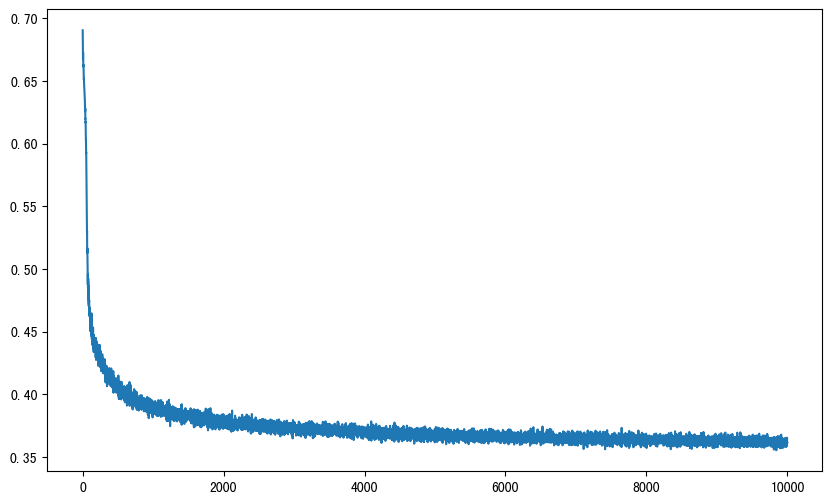

In [ ]:
lr = 0.001
epoch = 10000
model1, ls_metric1 = train_loop(train_data1, lr, epoch)
plot_loss(ls_metric1)

In [ ]:
lr = 0.0005
epoch = 5000
model2, ls_metric2 = train_loop(train_data2, lr, epoch)
plot_loss(ls_metric2)

Epoch: 0001, Loss: 0.6932
Epoch: 0002, Loss: 0.6931
Epoch: 0003, Loss: 0.6931
Epoch: 0004, Loss: 0.6931
Epoch: 0005, Loss: 0.6930
Epoch: 0006, Loss: 0.6930
Epoch: 0007, Loss: 0.6930
Epoch: 0008, Loss: 0.6929
Epoch: 0009, Loss: 0.6929
Epoch: 0010, Loss: 0.6928
Epoch: 0011, Loss: 0.6928
Epoch: 0012, Loss: 0.6927
Epoch: 0013, Loss: 0.6926
Epoch: 0014, Loss: 0.6924
Epoch: 0015, Loss: 0.6923
Epoch: 0016, Loss: 0.6921
Epoch: 0017, Loss: 0.6920
Epoch: 0018, Loss: 0.6917
Epoch: 0019, Loss: 0.6914
Epoch: 0020, Loss: 0.6911
Epoch: 0021, Loss: 0.6907
Epoch: 0022, Loss: 0.6902
Epoch: 0023, Loss: 0.6897
Epoch: 0024, Loss: 0.6892
Epoch: 0025, Loss: 0.6885
Epoch: 0026, Loss: 0.6878
Epoch: 0027, Loss: 0.6870
Epoch: 0028, Loss: 0.6861
Epoch: 0029, Loss: 0.6849
Epoch: 0030, Loss: 0.6840
Epoch: 0031, Loss: 0.6829
Epoch: 0032, Loss: 0.6815
Epoch: 0033, Loss: 0.6801
Epoch: 0034, Loss: 0.6787
Epoch: 0035, Loss: 0.6775
Epoch: 0036, Loss: 0.6759
Epoch: 0037, Loss: 0.6745
Epoch: 0038, Loss: 0.6721
Epoch: 0039,

In [ ]:
lr = 0.005
epoch = 5000
model3, ls_metric3 = train_loop(train_data3, lr, epoch)
plot_loss(ls_metric3)

Epoch: 0001, Loss: 0.6931
Epoch: 0002, Loss: 0.6945
Epoch: 0003, Loss: 0.6931
Epoch: 0004, Loss: 0.6928
Epoch: 0005, Loss: 0.6924
Epoch: 0006, Loss: 0.6913
Epoch: 0007, Loss: 0.6890
Epoch: 0008, Loss: 0.6860
Epoch: 0009, Loss: 0.6826
Epoch: 0010, Loss: 0.6780
Epoch: 0011, Loss: 0.6734
Epoch: 0012, Loss: 0.6655
Epoch: 0013, Loss: 0.6589
Epoch: 0014, Loss: 0.6487
Epoch: 0015, Loss: 0.6408
Epoch: 0016, Loss: 0.6377
Epoch: 0017, Loss: 0.6329
Epoch: 0018, Loss: 0.6295
Epoch: 0019, Loss: 0.6329
Epoch: 0020, Loss: 0.6300
Epoch: 0021, Loss: 0.6294
Epoch: 0022, Loss: 0.6176
Epoch: 0023, Loss: 0.6143
Epoch: 0024, Loss: 0.6084
Epoch: 0025, Loss: 0.6107
Epoch: 0026, Loss: 0.6186
Epoch: 0027, Loss: 0.6100
Epoch: 0028, Loss: 0.6128
Epoch: 0029, Loss: 0.6077
Epoch: 0030, Loss: 0.6131
Epoch: 0031, Loss: 0.6101
Epoch: 0032, Loss: 0.6057
Epoch: 0033, Loss: 0.6047
Epoch: 0034, Loss: 0.6017
Epoch: 0035, Loss: 0.6050
Epoch: 0036, Loss: 0.6016
Epoch: 0037, Loss: 0.6039
Epoch: 0038, Loss: 0.6011
Epoch: 0039,

In [ ]:
test1_pred = predict(test_data1, model1)
pd.DataFrame({
    'id': df_test1['id'],
    'prob': test1_pred.tolist()
}).to_csv('test1_upload.csv', index=False)

In [ ]:
test2_pred = predict(test_data2, model2)
pd.DataFrame({
    'id': df_test2['id'],
    'prob': test2_pred.tolist()
}).to_csv('test2_upload.csv', index=False)

In [ ]:
test3_pred = predict(test_data3, model3)
pd.DataFrame({
    'id': df_test3['id'],
    'prob': test3_pred.tolist()
}).to_csv('test3_upload.csv', index=False)

## visualization

In [ ]:
ls_metric1

[[0.6929272413253784, 0.6972307956104251],
 [0.6927714943885803, 0.6909722222222222],
 [0.6925144791603088, 0.6825274348422496],
 [0.6921702027320862, 0.6704389574759946],
 [0.6916347146034241, 0.6594221536351165],
 [0.6909247636795044, 0.6521776406035665],
 [0.6900559663772583, 0.647633744855967],
 [0.6887374520301819, 0.6438614540466393],
 [0.6875483989715576, 0.6406893004115226],
 [0.6861222386360168, 0.6373456790123455],
 [0.6845959424972534, 0.6340020576131686],
 [0.6829423308372498, 0.6313443072702332],
 [0.6830015182495117, 0.6301011659807956],
 [0.6821644902229309, 0.6295438957475995],
 [0.6817758679389954, 0.6266289437585734],
 [0.6803196668624878, 0.6237997256515776],
 [0.6802513003349304, 0.6215706447187929],
 [0.6776667237281799, 0.618227023319616],
 [0.6767279505729675, 0.6160836762688615],
 [0.6754955053329468, 0.6131687242798354],
 [0.6743124127388, 0.6103395061728396],
 [0.6735402345657349, 0.6102537722908092],
 [0.6718125939369202, 0.6093964334705075],
 [0.670627474784

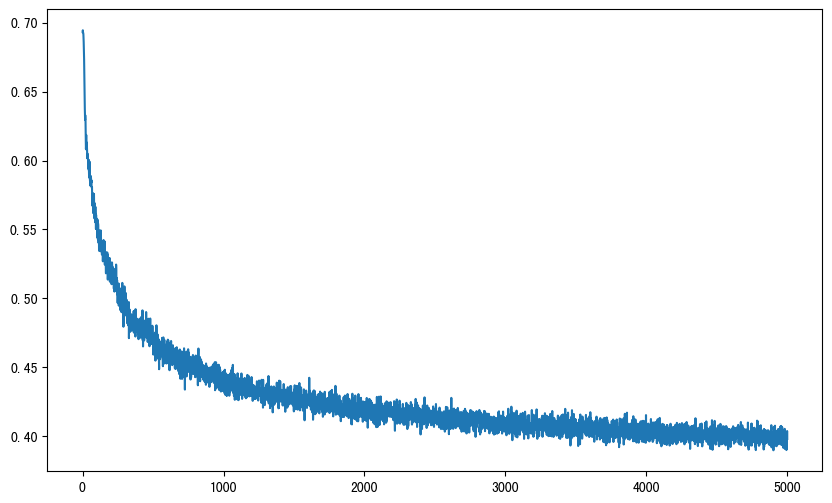